In [1]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(1707, 20, 14, 1)
(426, 20, 14, 1)
(1707, 4)
(426, 4)

Train labels:
[3. 0. 0. ... 3. 1. 3.]
Test labels:
[3. 3. 3. 3. 0. 2. 1. 0. 2. 1. 0. 1. 0. 0. 0. 3. 0. 0. 3. 3. 0. 1. 2. 3.
 1. 2. 3. 3. 0. 1. 1. 1. 1. 2. 0. 0. 3. 0. 1. 1. 3. 3. 2. 2. 3. 3. 0. 3.
 0. 3. 1. 2. 2. 1. 2. 0. 2. 1. 3. 2. 0. 2. 0. 2. 0. 0. 1. 3. 0. 1. 2. 2.
 0. 3. 1. 1. 2. 2. 0. 2. 2. 3. 0. 0. 0. 3. 2. 3. 1. 0. 0. 0. 3. 2. 2. 1.
 0. 0. 3. 3. 1. 0. 0. 1. 0. 0. 0. 1. 3. 2. 2. 1. 3. 0. 3. 1. 0. 0. 0. 0.
 0. 0. 0. 1. 2. 0. 3. 0. 0. 2. 2. 2. 2. 2. 1. 3. 1. 0. 0. 3. 2. 0. 3. 3.
 2. 2. 0. 0. 0. 3. 0. 3. 0. 0. 1. 0. 0. 0. 0. 3. 3. 2. 0. 1. 0. 2. 1. 1.
 2. 2. 0. 2. 3. 1. 1. 3. 0. 0. 1. 3. 0. 2. 1. 0. 1. 0. 0. 0. 3. 0. 2. 0.
 0. 2. 2. 0. 3. 2. 1. 2. 2. 3. 2. 3. 2. 0. 0. 1. 0. 0. 2. 1. 0. 3. 0. 2.
 3. 1. 0. 2. 2. 1. 0. 0. 1. 1. 1. 0. 2. 3. 3. 3. 3. 0. 3. 0. 2. 1. 0. 1.
 0. 3. 2. 0. 1. 3. 2. 3. 3. 3. 3. 1. 3. 2. 2. 0. 0. 2. 2. 0. 0. 2. 3. 3.
 1. 0. 0. 1. 0. 0. 3. 0. 0. 3. 2. 2. 1. 2. 0. 0. 3. 2. 2. 1. 2. 0. 0. 2.
 2. 2. 1. 1. 2. 1.

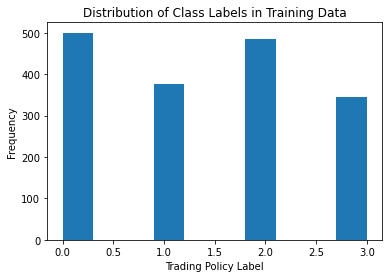

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import stats

IMG_SIZE = 20

for ticker in tickers:
    data = pd.read_csv(f'./data_with_labels/{ticker}_with_labels.csv')
    features, labels = data.drop(['policy', 'Date'], axis=1), data['policy']

    if (ticker == "AMZN"):
        X = features.to_numpy()
        y = labels.to_numpy()
    else:
        X_new = features.to_numpy()
        y_new = labels.to_numpy()
        X = np.concatenate((X, X_new), axis=0)
        y = np.concatenate((y, y_new), axis=0)

# center each feature with 0 mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# reshape the data into 2D images 
num_timestamps = X.shape[0]
img_size = IMG_SIZE
num_imgs = num_timestamps // img_size
X = X[: num_imgs * img_size, :]
y = y[: num_imgs * img_size]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(int(.2 * num_imgs)/num_imgs), shuffle=True)

X_train = np.reshape(X_train, (-1, img_size, 14, 1))
X_test = np.reshape(X_test, (-1, img_size, 14, 1))

# y_train_cat = np.round(np.median(np.reshape(y_train, (-1, img_size)), axis=1)).astype(int)
# y_test_cat = np.round(np.median(np.reshape(y_test, (-1, img_size)), axis=1)).astype(int)
y_train_cat = np.reshape(y_train, (-1, img_size))[:, -1]
y_test_cat = np.reshape(y_test, (-1, img_size))[:, -1]

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(y_train_cat[:, np.newaxis]).toarray()
y_test_enc = enc.fit_transform(y_test_cat[:, np.newaxis]).toarray()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test_enc.shape)

print("\nTrain labels:")
print(y_train_cat)
print("Test labels:")
print(y_test_cat)
print("\n")

h = plt.hist(y_train_cat)
txt = plt.title("Distribution of Class Labels in Training Data")
xlb = plt.xlabel("Trading Policy Label")
ylb = plt.ylabel("Frequency")

In [104]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, 14, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4))
    return model

In [103]:
model = create_model()
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, 
                    validation_data=(X_test, y_test_enc))

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 18, 12, 4)         40        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 6, 4, 4)           0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 4, 2, 8)           296       
_________________________________________________________________
flatten_30 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 260       
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 20        
Total params: 616
Trainable params: 616
Non-trainable params: 0
_______________________________________________________

14/14 - 0s - loss: 5.3430 - accuracy: 0.2488


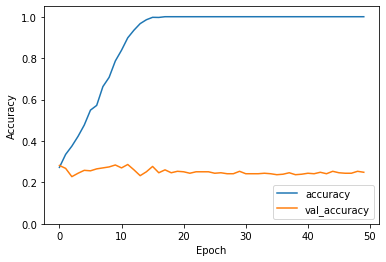

In [99]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.05])
plt.legend(loc='lower right')
plt.savefig('./cnn_figs/overfit_model_training.png')

test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)

In [100]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)



#     thresh = cm.numpy().max() / 1.5 if normalize else cm.numpy().max() / 2
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('./cnn_figs/overfit_confusion.png')
    plt.show()

(426,)
(426,)


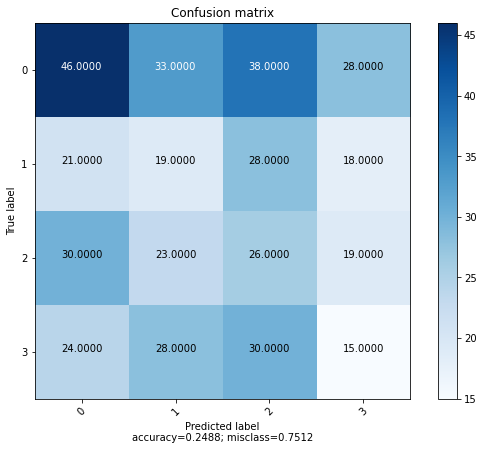

In [101]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

print(y_pred.shape)
print(y_test_cat.shape)
cm = confusion_matrix(y_test_cat, y_pred)
plot_confusion_matrix(cm, np.arange(4))